# CIFAR-100 Image Classification using ResNet (Residual Network) in PyTorch

ResNet, short for Residual Network is a specific type of neural network that was introduced in 2015 by Kaiming He, Xiangyu Zhang, Shaoqing Ren and Jian Sun in their paper [“Deep Residual Learning for Image Recognition”](https://arxiv.org/pdf/1512.03385.pdf). <br/>
ResNet was an innovative approach over VGG-like models:
* Won 1st place in the ILSVRC 2015 classification competition with a top-5 error rate of 3.57% (An ensemble model)
* Won the 1st place in ILSVRC and COCO 2015 competition in ImageNet Detection, ImageNet localization, Coco detection and Coco segmentation.
* Replacing VGG-16 layers in Faster R-CNN with ResNet-101. They observed relative improvements of 28%
* Efficiently trained networks with 100 layers and 1000 layers also.

We get over 70% accuracy without using any pre-trained model in 100 epochs and it proves the power of ResNet.

In this notebook, I will be implementing less complex version of ResNets to be able to get results in reasonable amount of time. Even though the implementation is done through CIFAR-100 dataset, it can be used with any image classification dataset. <br/>Note: Do not forget to change transform values if you use different the dataset. You can find the best parameters from SOTA implementations for well-known datasets.

#### References which I got implementations and explanations.
- [weiaicunzai/pytorch-cifar100](https://github.com/weiaicunzai/pytorch-cifar100/blob/master/models/resnet.py)
- [papers-with-code](https://paperswithcode.com/sota/image-classification-on-cifar-100)
- [pytorch-basic-cifar10](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html)
- [more-implementation-with-explanations](https://blog.jovian.ai/image-classification-of-cifar100-dataset-using-pytorch-8b7145242df1)
- [more-reading](https://www.researchgate.net/publication/355698607_MEST_Accurate_and_Fast_Memory-Economic_Sparse_Training_Framework_on_the_Edge)
- [visualization](https://jovian.ai/damian-c036/cifar100-final-project/v/5?utm_source=embed)


So we are good to go.


# Necessary Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import CIFAR100
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split, ConcatDataset
import torchvision.transforms as tt


____
#### Before we load the data, it is required to first prepare the transformations to be applied. It is an important step to prepare the data for training to avoid overfitting problem.
____

In [2]:
stats = ((0.5074,0.4867,0.4411),(0.2011,0.1987,0.2025))
train_transform = tt.Compose([
    tt.RandomHorizontalFlip(),
    tt.RandomCrop(32, padding=4, padding_mode="reflect"),
    tt.ToTensor(),
    tt.Normalize(*stats)
])

test_transform = tt.Compose([
    tt.ToTensor(),
    tt.Normalize(*stats)
])

___
RandomHorizontalFlip randomly flips an image with a probability of 50%, and RandomCrop pads an image by 4 pixel on each side then randomly crops 32x32 from the image after padding. We add such transformations to add noise to the data and prevent our model from overfitting. There are also other transformations you can use such as ColorJitter and RandomVerticalFlip etc. but I found these to be sufficient for our purposes. <br />

ToTensor simply converts the image to a Tensor. Since its a coloured image, it would have 3 channels (R,G,B) so the Tensor would be of size 3x32x32. <br/>

Normalize takes the mean and standard deviation for each channel of the entire dataset as input. Normalizing scales our data to a similar range of values to make sure that our gradients don’t go out of control.
Now we just prepare our train and test dataset and then we can explore the data.
___

# Loading Data

In [3]:
train_data = CIFAR100(download=True, root="./data", transform=train_transform)
test_data = CIFAR100(root="./data", train=False, transform=test_transform)

Files already downloaded and verified


_____

In [4]:
for image, label in train_data:
    print("Image shape: ",image.shape)
    print("Image tensor: ", image)
    print("Label: ", label)
    break

Image shape:  torch.Size([3, 32, 32])
Image tensor:  tensor([[[-0.1831,  0.3825,  0.7335,  ...,  2.4495,  2.4300,  2.4495],
         [-0.0660,  0.2850,  0.5385,  ...,  2.4495,  2.4300,  2.4495],
         [ 0.5385,  0.4800,  0.5190,  ...,  2.4495,  2.4300,  2.4495],
         ...,
         [ 0.2265, -0.6316, -2.0941,  ..., -0.0660, -0.1831, -0.1441],
         [-1.0411, -1.2556, -1.9381,  ...,  0.2070,  0.2460,  0.3630],
         [-0.9631, -1.1581, -1.5676,  ...,  0.5580,  0.5970,  0.4605]],

        [[ 0.1360,  0.7478,  1.1228,  ...,  2.5833,  2.5636,  2.5833],
         [ 0.1755,  0.5505,  0.7873,  ...,  2.5833,  2.5636,  2.5833],
         [ 0.8268,  0.6886,  0.5110,  ...,  2.5833,  2.5636,  2.5833],
         ...,
         [ 0.7281, -0.2390, -2.1336,  ...,  0.7084,  0.6097,  0.6492],
         [-0.9297, -1.2258, -2.1139,  ...,  1.0833,  1.1426,  1.2018],
         [-0.9692, -1.2653, -1.7784,  ...,  1.4781,  1.5373,  1.3794]],

        [[-0.4547, -0.0480,  0.4361,  ...,  2.7600,  2.7406,  2

In [5]:
train_classes_items = dict()

for train_item in train_data:
    label = train_data.classes[train_item[1]]
    if label not in train_classes_items:
        train_classes_items[label] = 1
    else:
        train_classes_items[label] += 1

train_classes_items

{'cattle': 500,
 'dinosaur': 500,
 'apple': 500,
 'boy': 500,
 'aquarium_fish': 500,
 'telephone': 500,
 'train': 500,
 'cup': 500,
 'cloud': 500,
 'elephant': 500,
 'keyboard': 500,
 'willow_tree': 500,
 'sunflower': 500,
 'castle': 500,
 'sea': 500,
 'bicycle': 500,
 'wolf': 500,
 'squirrel': 500,
 'shrew': 500,
 'pine_tree': 500,
 'rose': 500,
 'television': 500,
 'table': 500,
 'possum': 500,
 'oak_tree': 500,
 'leopard': 500,
 'maple_tree': 500,
 'rabbit': 500,
 'chimpanzee': 500,
 'clock': 500,
 'streetcar': 500,
 'cockroach': 500,
 'snake': 500,
 'lobster': 500,
 'mountain': 500,
 'palm_tree': 500,
 'skyscraper': 500,
 'tractor': 500,
 'shark': 500,
 'butterfly': 500,
 'bottle': 500,
 'bee': 500,
 'chair': 500,
 'woman': 500,
 'hamster': 500,
 'otter': 500,
 'seal': 500,
 'lion': 500,
 'mushroom': 500,
 'girl': 500,
 'sweet_pepper': 500,
 'forest': 500,
 'crocodile': 500,
 'orange': 500,
 'tulip': 500,
 'mouse': 500,
 'camel': 500,
 'caterpillar': 500,
 'man': 500,
 'skunk': 500

In [6]:
test_classes_items = dict()
for test_item in test_data:
    label = test_data.classes[test_item[1]]
    if label not in test_classes_items:
        test_classes_items[label] = 1
    else:
        test_classes_items[label] += 1

test_classes_items

{'mountain': 100,
 'forest': 100,
 'seal': 100,
 'mushroom': 100,
 'sea': 100,
 'tulip': 100,
 'camel': 100,
 'butterfly': 100,
 'cloud': 100,
 'apple': 100,
 'skunk': 100,
 'streetcar': 100,
 'rocket': 100,
 'lamp': 100,
 'lion': 100,
 'wolf': 100,
 'rose': 100,
 'orange': 100,
 'dinosaur': 100,
 'chimpanzee': 100,
 'can': 100,
 'keyboard': 100,
 'bicycle': 100,
 'chair': 100,
 'plate': 100,
 'lawn_mower': 100,
 'turtle': 100,
 'palm_tree': 100,
 'shark': 100,
 'pickup_truck': 100,
 'boy': 100,
 'couch': 100,
 'house': 100,
 'porcupine': 100,
 'cockroach': 100,
 'clock': 100,
 'castle': 100,
 'beaver': 100,
 'bee': 100,
 'bottle': 100,
 'pear': 100,
 'baby': 100,
 'flatfish': 100,
 'oak_tree': 100,
 'leopard': 100,
 'snail': 100,
 'crocodile': 100,
 'rabbit': 100,
 'beetle': 100,
 'girl': 100,
 'sunflower': 100,
 'raccoon': 100,
 'train': 100,
 'ray': 100,
 'trout': 100,
 'bowl': 100,
 'snake': 100,
 'orchid': 100,
 'tractor': 100,
 'caterpillar': 100,
 'bus': 100,
 'mouse': 100,
 'cr

# BATCHSIZE & DataLoader

In [7]:
BATCH_SIZE = 128
train_dl = DataLoader(train_data, BATCH_SIZE, num_workers=4, pin_memory=True, shuffle=True)
test_dl = DataLoader(test_data, BATCH_SIZE, num_workers=4, pin_memory=True)

# Visualization

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


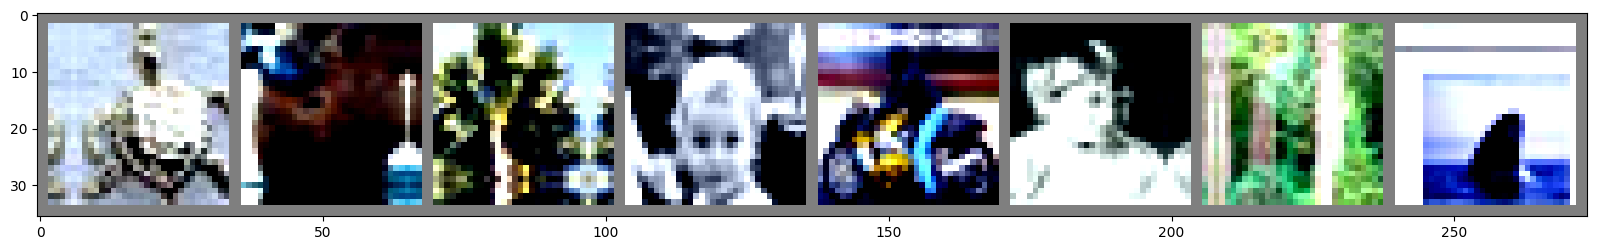

turtle              cattle              palm_tree           boy                 motorcycle          boy                 forest              whale               


In [8]:
# for 8 images
train_8_samples = DataLoader(train_data, 8, num_workers=4, pin_memory=True, shuffle=True)

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.figure(figsize = (20,20))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(train_8_samples)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print(''.join(f'{train_data.classes[labels[j]]:20s}' for j in range(8)))

# Get CUDA ready

In [9]:
def get_device():
    if torch.cuda.is_available():
        return torch.device("cuda")
    return torch.device("cpu")

def to_device(data,device):
    if isinstance(data,(list,tuple)):
        return [to_device(x,device) for x in data]
    return data.to(device,non_blocking=True)


class ToDeviceLoader:
    def __init__(self,data,device):
        self.data = data
        self.device = device
        
    def __iter__(self):
        for batch in self.data:
            yield to_device(batch,self.device)
            
    def __len__(self):
        return len(self.data)


In [10]:
device = get_device()
print(device)

train_dl = ToDeviceLoader(train_dl, device)
test_dl = ToDeviceLoader(test_dl, device)

cuda


In [11]:
def accuracy(predicted, actual):
    _, predictions = torch.max(predicted, dim=1)
    return torch.tensor(torch.sum(predictions==actual).item()/len(predictions))

# BaseModel

In [12]:
class BaseModel(nn.Module):
    def training_step(self,batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out,labels)
        return loss
    
    def validation_step(self,batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out,labels)
        acc = accuracy(out,labels)
        return {"val_loss":loss.detach(),"val_acc":acc}
    
    def validation_epoch_end(self,outputs):
        batch_losses = [loss["val_loss"] for loss in outputs]
        loss = torch.stack(batch_losses).mean()
        batch_accuracy = [accuracy["val_acc"] for accuracy in outputs]
        acc = torch.stack(batch_accuracy).mean()
        return {"val_loss":loss.item(),"val_acc":acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))

# ResNet Implementation

BaseModel allows us to check and record the results of our model every time we train and pretty much just helps us keep track of our progress. This is what our actual model will inherit. <br />

I implemented ResNet with changing a little bit that worked better than the one I got and used as base.<br />

#### An example figure of ResNet approach to understand easily what we will see below as code:

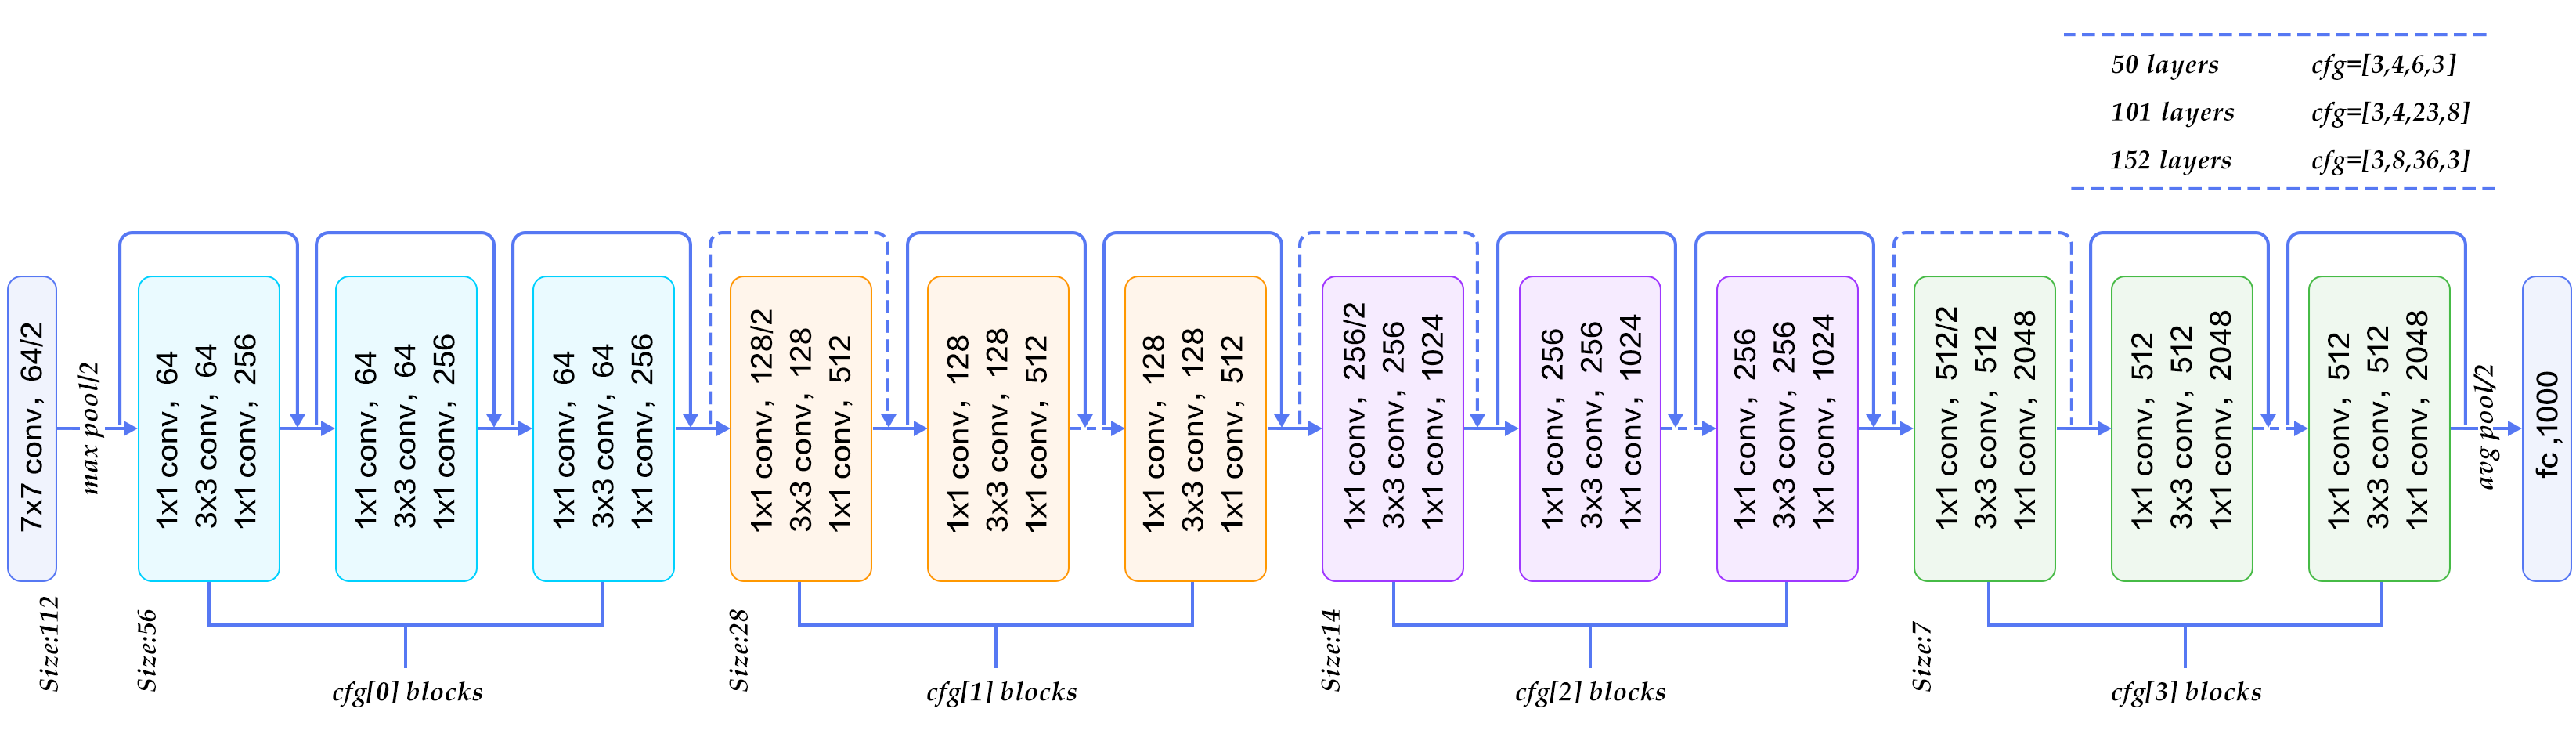
<br/><br/><br/><br/>
____



In [13]:
def conv_shortcut(in_channel, out_channel, stride):
    layers = [nn.Conv2d(in_channel, out_channel, kernel_size=(1,1), stride=(stride, stride)),
             nn.BatchNorm2d(out_channel)]
    return nn.Sequential(*layers)

def block(in_channel, out_channel, k_size,stride, conv=False):
    layers = None
    
    first_layers = [nn.Conv2d(in_channel,out_channel[0], kernel_size=(1,1),stride=(1,1)),
                    nn.BatchNorm2d(out_channel[0]),
                    nn.ReLU(inplace=True)]
    if conv:
        first_layers[0].stride=(stride,stride)
    
    second_layers = [nn.Conv2d(out_channel[0], out_channel[1], kernel_size=(k_size, k_size), stride=(1,1), padding=1),
                    nn.BatchNorm2d(out_channel[1])]

    layers = first_layers + second_layers
    
    return nn.Sequential(*layers)
    

class ResNet(BaseModel):
    
    def __init__(self, in_channels, num_classes):
        super().__init__()
        
        self.stg1 = nn.Sequential(
                                   nn.Conv2d(in_channels=in_channels, out_channels=64, kernel_size=(3),
                                             stride=(1), padding=1),
                                   nn.BatchNorm2d(64),
                                   nn.ReLU(inplace=True),
                                   nn.MaxPool2d(kernel_size=3, stride=2))
        
        ##stage 2
        self.convShortcut2 = conv_shortcut(64,256,1)
        
        self.conv2 = block(64,[64,256],3,1,conv=True)
        self.ident2 = block(256,[64,256],3,1)

        
        ##stage 3
        self.convShortcut3 = conv_shortcut(256,512,2)
        
        self.conv3 = block(256,[128,512],3,2,conv=True)
        self.ident3 = block(512,[128,512],3,2)

        
        ##stage 4
        self.convShortcut4 = conv_shortcut(512,1024,2)
        
        self.conv4 = block(512,[256,1024],3,2,conv=True)
        self.ident4 = block(1024,[256,1024],3,2)
        
        
        ##Classify
        self.classifier = nn.Sequential(
                                       nn.AvgPool2d(kernel_size=(4)),
                                       nn.Flatten(),
                                       nn.Linear(1024, num_classes))
        
    def forward(self,inputs):
        out = self.stg1(inputs)
        
        #stage 2
        out = F.relu(self.conv2(out) + self.convShortcut2(out))
        out = F.relu(self.ident2(out) + out)
        out = F.relu(self.ident2(out) + out)
        out = F.relu(self.ident2(out) + out)
        
        #stage3
        out = F.relu(self.conv3(out) + (self.convShortcut3(out)))
        out = F.relu(self.ident3(out) + out)
        out = F.relu(self.ident3(out) + out)
        out = F.relu(self.ident3(out) + out)
        out = F.relu(self.ident3(out) + out)
        
        #stage4             
        out = F.relu(self.conv4(out) + (self.convShortcut4(out)))
        out = F.relu(self.ident4(out) + out)
        out = F.relu(self.ident4(out) + out)
        out = F.relu(self.ident4(out) + out)
        out = F.relu(self.ident4(out) + out)
        out = F.relu(self.ident4(out) + out)
        out = F.relu(self.ident4(out) + out)
        
        #Classify
        out = self.classifier(out)#100x1024
        
        return out
        

In [14]:
model = ResNet(3,100)

In [15]:
model = to_device(model, device)

# Evaluation & Fit Function for Training

In [16]:
@torch.no_grad()
def evaluate(model,test_dl):
    model.eval()
    outputs = [model.validation_step(batch) for batch in test_dl]
    return model.validation_epoch_end(outputs)

In [17]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit (epochs, train_dl, test_dl, model, optimizer, max_lr, weight_decay, scheduler, grad_clip=None):
    torch.cuda.empty_cache()
    
    history = []
    
    optimizer = optimizer(model.parameters(), max_lr, weight_decay = weight_decay)
    
    scheduler = scheduler(optimizer, max_lr, epochs=epochs, steps_per_epoch=len(train_dl))
    
    for epoch in range(epochs):
        model.train()
        
        train_loss = []
        
        lrs = []
        
        for batch in train_dl:
            loss = model.training_step(batch)
            
            train_loss.append(loss)
            
            loss.backward()
            
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            scheduler.step()
            lrs.append(get_lr(optimizer))
        result = evaluate(model, test_dl)
        result["train_loss"] = torch.stack(train_loss).mean().item()
        result["lrs"] = lrs
        
        model.epoch_end(epoch,result)
        history.append(result)
        
    return history
            

# Hyperparameters

- **max_lr**: is the maximum learning rate that we set for learning rate scheduler. For the learning rate scheduler we used OneCycleLR, which sets the learning rate to a low learning rate, gradually increases it to the max learning rate then goes back to a low learning rate. <br/>
- **grad_clip**: prevents the gradients to become too large. <br/>
- **weight_decay**: essentially tries to make the model simple and helps the model generalise better.


In [18]:
epochs = 100
optimizer = torch.optim.Adam
max_lr = 1e-3
grad_clip = 0.1
weight_decay = 1e-5
scheduler = torch.optim.lr_scheduler.OneCycleLR

# Training

In [19]:
%%time
history = fit(epochs=epochs, train_dl=train_dl, test_dl=test_dl, model=model, 
              optimizer=optimizer, max_lr=max_lr, grad_clip=grad_clip,
              weight_decay=weight_decay, scheduler=torch.optim.lr_scheduler.OneCycleLR)

Epoch [0], last_lr: 0.00004, train_loss: 3.8498, val_loss: 4.1866, val_acc: 0.0817
Epoch [1], last_lr: 0.00005, train_loss: 3.1971, val_loss: 4.0063, val_acc: 0.1100
Epoch [2], last_lr: 0.00006, train_loss: 2.8811, val_loss: 3.6180, val_acc: 0.1722
Epoch [3], last_lr: 0.00008, train_loss: 2.6345, val_loss: 3.4152, val_acc: 0.1944
Epoch [4], last_lr: 0.00010, train_loss: 2.4472, val_loss: 3.1527, val_acc: 0.2341
Epoch [5], last_lr: 0.00013, train_loss: 2.2967, val_loss: 2.9101, val_acc: 0.2743
Epoch [6], last_lr: 0.00016, train_loss: 2.1785, val_loss: 2.7724, val_acc: 0.2963
Epoch [7], last_lr: 0.00020, train_loss: 2.0823, val_loss: 2.5616, val_acc: 0.3305
Epoch [8], last_lr: 0.00024, train_loss: 1.9831, val_loss: 2.5358, val_acc: 0.3448
Epoch [9], last_lr: 0.00028, train_loss: 1.9157, val_loss: 2.5141, val_acc: 0.3451
Epoch [10], last_lr: 0.00032, train_loss: 1.8472, val_loss: 2.3114, val_acc: 0.3825
Epoch [11], last_lr: 0.00037, train_loss: 1.7931, val_loss: 2.2845, val_acc: 0.4133
Ep

# Plotting

In [20]:
def plot_acc(history):
    plt.plot([x["val_acc"] for x in history],"-x")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")

def plot_loss(history):
    plt.plot([x.get("train_loss") for x in history], "-bx")
    plt.plot([x["val_loss"] for x in history],"-rx")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(["train loss","val loss"])
    
def plot_lrs(history):
    plt.plot(np.concatenate([x.get("lrs",[]) for x in history]))
    plt.xlabel("Batch number")
    plt.ylabel("Learning rate")

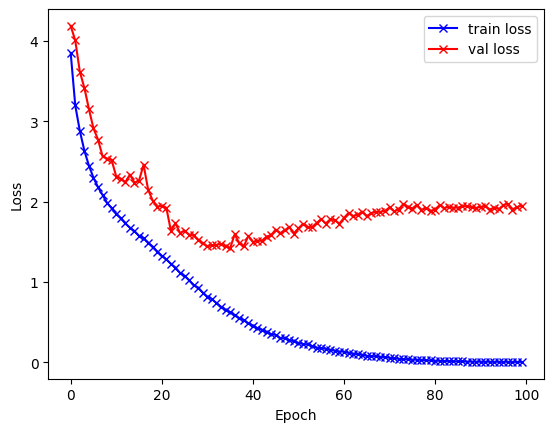

In [21]:
plot_loss(history)

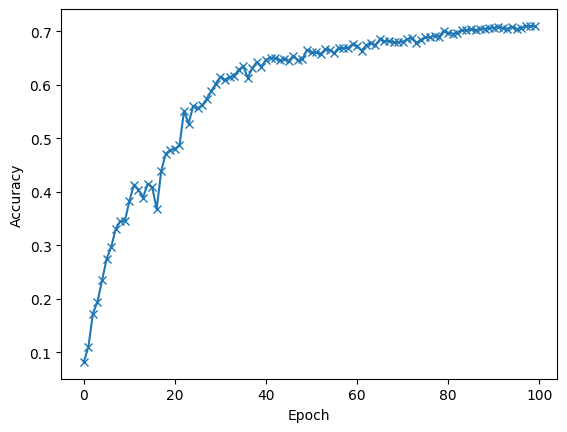

In [22]:
plot_acc(history)

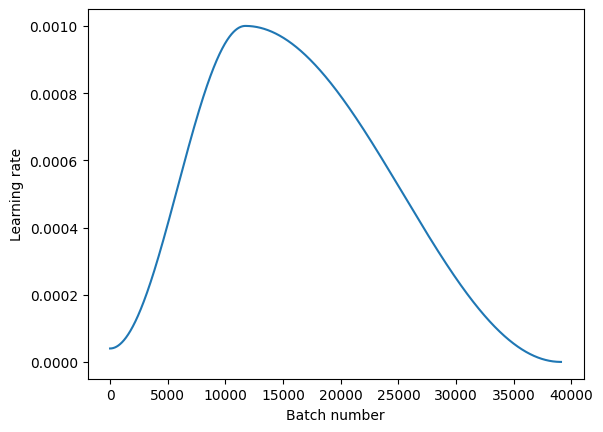

In [23]:
plot_lrs(history)

# Make predictions and see the image with its result


In [24]:
def predict_image(img, model):
    xb = to_device(img.unsqueeze(0), device)
    yb = model(xb)
    _, preds  = torch.max(yb, dim=1)
    return test_data.classes[preds[0].item()]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: mountain , Predicted: spider


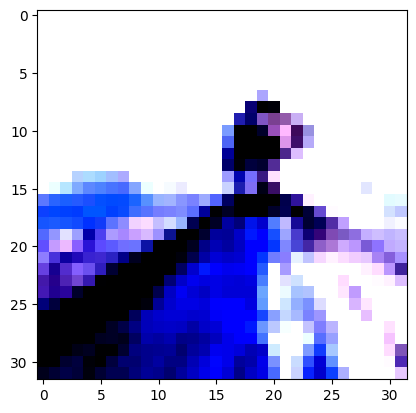

In [25]:
img, label = test_data[0]
plt.imshow(img.permute(1, 2, 0))
print('Label:', test_data.classes[label], ', Predicted:', predict_image(img, model))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: wardrobe , Predicted: wardrobe


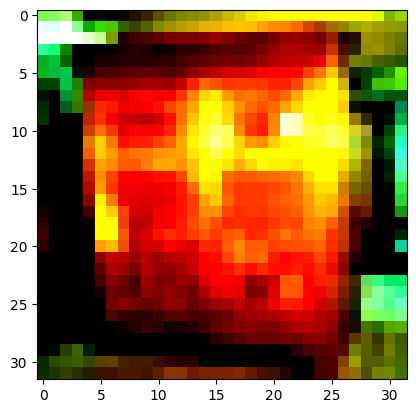

In [26]:
img, label = test_data[1002]
plt.imshow(img.permute(1, 2, 0))
print('Label:', test_data.classes[label], ', Predicted:', predict_image(img, model))

# Save

In [27]:
torch.save(model.state_dict(), 'cifar100-resnet-project.pth')

In [28]:
print("finish")

finish


In [29]:

def test_accuracy(model, test_data):

    correct = 0
    for image, label in test_data:
        
        y = predict_image(image, model)
        if y == test_data.classes[label]:
            correct += 1

    return correct/len(test_data)
    

In [30]:
test_accuracy(model, test_data)

0.7089